In [1]:
from pyspark.sql import SparkSession

In [2]:

spark=SparkSession.builder.getOrCreate()


In [3]:
df=spark.read.option("header","true")\
        .option("delimiter","\t")\
        .option("inferSchema","true")\
        .csv("customers.txt")
df.show()

+--------+----------+---------+------+---------+-----+
|deviceid|customerid|    price|alerts| location|state|
+--------+----------+---------+------+---------+-----+
|       1|        11|      100|    14|Bengaluru|   KA|
|       2|        22|"""200"""|    25|   Mysuru|   KA|
|       3|        33|      300|     6|       AP| NULL|
|       4|        44|      ten|     7|  Chennai|   TN|
|       5|      NULL|      250|     8| Hubballi|   KA|
|       6|        66|      600|     9|    Bidar|   KA|
|       7|        77|     NULL|     7| Belagavi|   KA|
+--------+----------+---------+------+---------+-----+



In [4]:
df=df.withColumnRenamed("deviceid","Device ID")\
     .withColumnRenamed("customerid","Customer ID")\
     .withColumnRenamed("price","Price")\
     .withColumnRenamed("alerts","Alerts")\
     .withColumnRenamed("location","City")\
     .withColumnRenamed("state","State")
df.show()
    
    
    

+---------+-----------+---------+------+---------+-----+
|Device ID|Customer ID|    Price|Alerts|     City|State|
+---------+-----------+---------+------+---------+-----+
|        1|         11|      100|    14|Bengaluru|   KA|
|        2|         22|"""200"""|    25|   Mysuru|   KA|
|        3|         33|      300|     6|       AP| NULL|
|        4|         44|      ten|     7|  Chennai|   TN|
|        5|       NULL|      250|     8| Hubballi|   KA|
|        6|         66|      600|     9|    Bidar|   KA|
|        7|         77|     NULL|     7| Belagavi|   KA|
+---------+-----------+---------+------+---------+-----+



In [5]:
if df.columns:  
    missing_count = df.select([df[col].isNull().alias(col) for col in df.columns]).rdd.flatMap(lambda row: row).sum()
    if missing_count > 0:
        print(f"The dataset contains {missing_count} missing values.")
    else:
        print("The dataset does not contain any missing values.")
else:
    print("The dataset is empty.")


The dataset contains 3 missing values.


In [6]:
from pyspark.sql.functions import col, sum as _sum, when


missing_values = df.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns
])


missing_values_dict = missing_values.collect()[0].asDict()
for column, missing_count in missing_values_dict.items():
    if missing_count > 0:
        print(f"Column '{column}' has {missing_count} missing values.")
    else:
        print(f"Column '{column}' has no missing values.")

Column 'Device ID' has no missing values.
Column 'Customer ID' has 1 missing values.
Column 'Price' has 1 missing values.
Column 'Alerts' has no missing values.
Column 'City' has no missing values.
Column 'State' has 1 missing values.


In [7]:
from pyspark.sql.functions import col, mean, when

# Calculate the mean price, ignoring nulls and invalid values
mean_price = df.filter(col("price").cast("float").isNotNull()) \
               .agg(mean(col("price").cast("float")).alias("mean_price")) \
               .collect()[0]["mean_price"]

# Fill missing or invalid values with the mean price
df = df.withColumn(
    "price",
    when(col("price").cast("float").isNotNull(), col("price").cast("float"))
    .otherwise(mean_price)
)

df.show()


+---------+-----------+-----+------+---------+-----+
|Device ID|Customer ID|price|Alerts|     City|State|
+---------+-----------+-----+------+---------+-----+
|        1|         11|100.0|    14|Bengaluru|   KA|
|        2|         22|312.5|    25|   Mysuru|   KA|
|        3|         33|300.0|     6|       AP| NULL|
|        4|         44|312.5|     7|  Chennai|   TN|
|        5|       NULL|250.0|     8| Hubballi|   KA|
|        6|         66|600.0|     9|    Bidar|   KA|
|        7|         77|312.5|     7| Belagavi|   KA|
+---------+-----------+-----+------+---------+-----+



In [8]:
# Drop rows with missing values in 'Device ID' or 'Customer ID' columns
df_cleaned = df.dropna(subset=["Device ID", "Customer ID"])

# Show the cleaned DataFrame
df_cleaned.show()


+---------+-----------+-----+------+---------+-----+
|Device ID|Customer ID|price|Alerts|     City|State|
+---------+-----------+-----+------+---------+-----+
|        1|         11|100.0|    14|Bengaluru|   KA|
|        2|         22|312.5|    25|   Mysuru|   KA|
|        3|         33|300.0|     6|       AP| NULL|
|        4|         44|312.5|     7|  Chennai|   TN|
|        6|         66|600.0|     9|    Bidar|   KA|
|        7|         77|312.5|     7| Belagavi|   KA|
+---------+-----------+-----+------+---------+-----+



In [9]:
spark.stop()

In [10]:
from pyspark.sql import SparkSession

import random
import time
from pyspark.sql.functions import from_unixtime,avg,count

In [11]:
spark=SparkSession.builder.getOrCreate()

In [12]:

num_movies = 50
num_users = 100
num_records = 1000

data = []
for _ in range(num_records):
    MovieID = random.randint(1, num_movies)
    UserID = random.randint(1, num_users)
    Rating = random.randint(1, 5)
    Timestamp = random.randint(1000000000, int(time.time()))
    data.append((MovieID, UserID, Rating, Timestamp))


schema = ["MovieID", "UserID", "Rating", "Timestamp"]

df = spark.createDataFrame(data, schema=schema)

In [13]:
df.show()
df.count()

+-------+------+------+----------+
|MovieID|UserID|Rating| Timestamp|
+-------+------+------+----------+
|     31|    88|     2|1231402040|
|      9|    87|     4|1700612632|
|      6|    63|     5|1262336762|
|     17|    33|     3|1531475648|
|     21|    80|     1|1624852591|
|     19|    34|     2|1194726774|
|     26|     9|     1|1647725148|
|     20|    26|     5|1528432124|
|      9|    26|     1|1267129569|
|     29|    88|     4|1290235099|
|      2|    59|     3|1584190906|
|      8|    42|     4|1009172913|
|     27|    97|     1|1443544679|
|     28|    49|     5|1659790581|
|     48|    15|     2|1054322991|
|     43|     7|     5|1550394803|
|     44|    69|     4|1330892567|
|      3|    51|     5|1092840925|
|     32|    73|     3|1714209900|
|     25|    40|     4|1309337065|
+-------+------+------+----------+
only showing top 20 rows



1000

In [14]:
df=df.withColumn("ReadableDate", from_unixtime(df['Timestamp'], "yyyy-MM-dd HH:mm:ss"))
df.show()

+-------+------+------+----------+-------------------+
|MovieID|UserID|Rating| Timestamp|       ReadableDate|
+-------+------+------+----------+-------------------+
|     31|    88|     2|1231402040|2009-01-08 13:37:20|
|      9|    87|     4|1700612632|2023-11-22 05:53:52|
|      6|    63|     5|1262336762|2010-01-01 14:36:02|
|     17|    33|     3|1531475648|2018-07-13 15:24:08|
|     21|    80|     1|1624852591|2021-06-28 09:26:31|
|     19|    34|     2|1194726774|2007-11-11 02:02:54|
|     26|     9|     1|1647725148|2022-03-20 02:55:48|
|     20|    26|     5|1528432124|2018-06-08 09:58:44|
|      9|    26|     1|1267129569|2010-02-26 01:56:09|
|     29|    88|     4|1290235099|2010-11-20 12:08:19|
|      2|    59|     3|1584190906|2020-03-14 18:31:46|
|      8|    42|     4|1009172913|2001-12-24 11:18:33|
|     27|    97|     1|1443544679|2015-09-29 22:07:59|
|     28|    49|     5|1659790581|2022-08-06 18:26:21|
|     48|    15|     2|1054322991|2003-05-31 00:59:51|
|     43| 

In [15]:
df.groupBy("MovieID").agg(avg('Rating')).show()


+-------+------------------+
|MovieID|       avg(Rating)|
+-------+------------------+
|     26|2.6785714285714284|
|     29|2.8260869565217392|
|     19| 3.210526315789474|
|     22|               3.0|
|      7|              2.75|
|     34|               3.3|
|     50|               3.0|
|     43|              3.16|
|     32|2.8947368421052633|
|     31|               3.1|
|     39|2.9130434782608696|
|     25|2.9473684210526314|
|      6|3.1923076923076925|
|      9|              2.65|
|     27|             2.875|
|     17|               2.5|
|     41| 2.588235294117647|
|     28| 3.272727272727273|
|     33|2.7142857142857144|
|      5|              3.35|
+-------+------------------+
only showing top 20 rows



In [16]:
movie_count = df.groupBy('UserID').agg(count('MovieID').alias('MovieCount'))
movie_count.show()

+------+----------+
|UserID|MovieCount|
+------+----------+
|    26|        18|
|    29|         5|
|    65|        13|
|    54|         8|
|    22|        11|
|     7|         8|
|    34|        13|
|    50|         9|
|    94|        13|
|    57|        10|
|    32|         7|
|    43|        13|
|    84|         8|
|    31|        13|
|    39|         7|
|    25|        13|
|    95|         8|
|    71|        10|
|    68|        11|
|     6|         8|
+------+----------+
only showing top 20 rows



In [17]:
usercount=movie_count.filter(movie_count['MovieCount']<5)
usercount.show()

+------+----------+
|UserID|MovieCount|
+------+----------+
|    67|         3|
|    19|         2|
|    77|         4|
+------+----------+



In [18]:
df.printSchema()

root
 |-- MovieID: long (nullable = true)
 |-- UserID: long (nullable = true)
 |-- Rating: long (nullable = true)
 |-- Timestamp: long (nullable = true)
 |-- ReadableDate: string (nullable = true)



In [19]:
df.select("MovieID","Rating").orderBy(df["Rating"].desc()).show(5)

+-------+------+
|MovieID|Rating|
+-------+------+
|     43|     5|
|     25|     5|
|     47|     5|
|     43|     5|
|     29|     5|
+-------+------+
only showing top 5 rows



In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of Movies Rated by Each User')

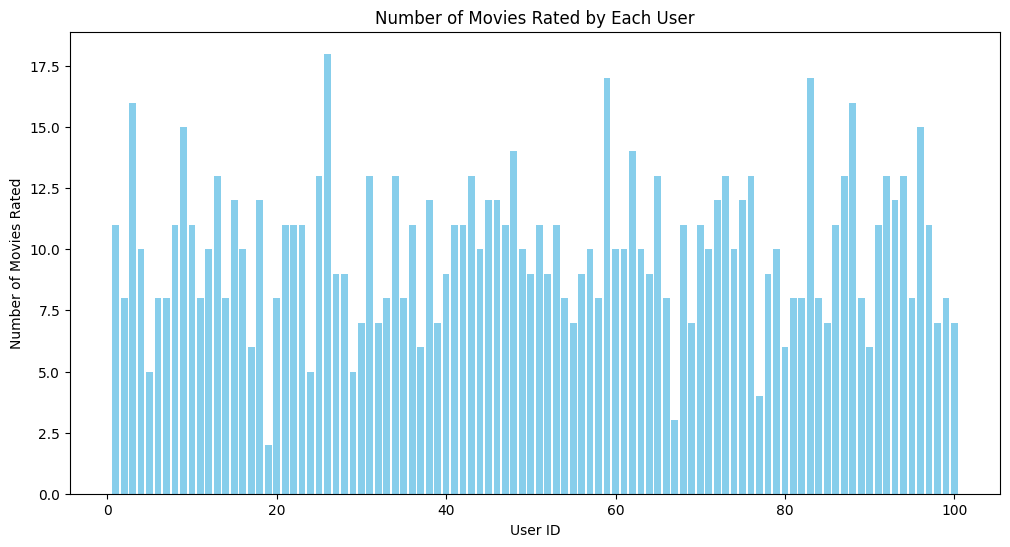

In [21]:
visualization=movie_count.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(visualization['UserID'], visualization['MovieCount'], color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.title('Number of Movies Rated by Each User')


In [22]:
from pyspark.sql.functions import col, hour, avg, desc,count
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [23]:
spark = SparkSession.builder \
    .appName("Trip Data Analysis") \
    .getOrCreate()

In [24]:
#Generate data with schema: TripID, StartTime, EndTime, Distance, Fare
data = [
    ("T1", "2024-12-20 08:30:00", "2024-12-20 09:00:00", 15.0, 25.0),
    ("T2", "2024-12-20 09:15:00", "2024-12-20 09:45:00", 20.0, 35.0),
    ("T3", "2024-12-20 10:00:00", "2024-12-20 10:45:00", 10.0, 15.0),
    ("T4", "2024-12-20 11:30:00", "2024-12-20 12:15:00", 30.0, 50.0),
    ("T5", "2024-12-20 13:00:00", "2024-12-20 14:00:00", 50.0, 75.0),
]
schema = ["TripID", "StartTime", "EndTime", "Distance", "Fare"]

In [25]:
trip_df = spark.createDataFrame(data, schema)
trip_df.show()

+------+-------------------+-------------------+--------+----+
|TripID|          StartTime|            EndTime|Distance|Fare|
+------+-------------------+-------------------+--------+----+
|    T1|2024-12-20 08:30:00|2024-12-20 09:00:00|    15.0|25.0|
|    T2|2024-12-20 09:15:00|2024-12-20 09:45:00|    20.0|35.0|
|    T3|2024-12-20 10:00:00|2024-12-20 10:45:00|    10.0|15.0|
|    T4|2024-12-20 11:30:00|2024-12-20 12:15:00|    30.0|50.0|
|    T5|2024-12-20 13:00:00|2024-12-20 14:00:00|    50.0|75.0|
+------+-------------------+-------------------+--------+----+



In [26]:
trip_df = trip_df.withColumn("FarePerMile", trip_df["Fare"] / trip_df["Distance"])
trip_df.show()
avg_fare = trip_df.select(avg("FarePerMile").alias("AvgFarePerMile")) #avg(column) gives average of the particular column 

avg_fare.show() #.alias will give new name of the column for this particular line of code

+------+-------------------+-------------------+--------+----+------------------+
|TripID|          StartTime|            EndTime|Distance|Fare|       FarePerMile|
+------+-------------------+-------------------+--------+----+------------------+
|    T1|2024-12-20 08:30:00|2024-12-20 09:00:00|    15.0|25.0|1.6666666666666667|
|    T2|2024-12-20 09:15:00|2024-12-20 09:45:00|    20.0|35.0|              1.75|
|    T3|2024-12-20 10:00:00|2024-12-20 10:45:00|    10.0|15.0|               1.5|
|    T4|2024-12-20 11:30:00|2024-12-20 12:15:00|    30.0|50.0|1.6666666666666667|
|    T5|2024-12-20 13:00:00|2024-12-20 14:00:00|    50.0|75.0|               1.5|
+------+-------------------+-------------------+--------+----+------------------+

+------------------+
|    AvgFarePerMile|
+------------------+
|1.6166666666666667|
+------------------+



In [27]:
from pyspark.sql.functions import unix_timestamp,from_unixtime

In [28]:
#Find the average fare per mile
trip_df = trip_df.withColumn(
    "TripDuration",
    (unix_timestamp(trip_df["EndTime"]) - unix_timestamp(trip_df["StartTime"])) / 60
)
trip_df.show()

+------+-------------------+-------------------+--------+----+------------------+------------+
|TripID|          StartTime|            EndTime|Distance|Fare|       FarePerMile|TripDuration|
+------+-------------------+-------------------+--------+----+------------------+------------+
|    T1|2024-12-20 08:30:00|2024-12-20 09:00:00|    15.0|25.0|1.6666666666666667|        30.0|
|    T2|2024-12-20 09:15:00|2024-12-20 09:45:00|    20.0|35.0|              1.75|        30.0|
|    T3|2024-12-20 10:00:00|2024-12-20 10:45:00|    10.0|15.0|               1.5|        45.0|
|    T4|2024-12-20 11:30:00|2024-12-20 12:15:00|    30.0|50.0|1.6666666666666667|        45.0|
|    T5|2024-12-20 13:00:00|2024-12-20 14:00:00|    50.0|75.0|               1.5|        60.0|
+------+-------------------+-------------------+--------+----+------------------+------------+



In [29]:
#Identify the top 3 longest trips based on distance
longest_trips = trip_df.orderBy(trip_df["Distance"].desc()) #it will sort distance in descending order
longest_trips.show(3)


+------+-------------------+-------------------+--------+----+------------------+------------+
|TripID|          StartTime|            EndTime|Distance|Fare|       FarePerMile|TripDuration|
+------+-------------------+-------------------+--------+----+------------------+------------+
|    T5|2024-12-20 13:00:00|2024-12-20 14:00:00|    50.0|75.0|               1.5|        60.0|
|    T4|2024-12-20 11:30:00|2024-12-20 12:15:00|    30.0|50.0|1.6666666666666667|        45.0|
|    T2|2024-12-20 09:15:00|2024-12-20 09:45:00|    20.0|35.0|              1.75|        30.0|
+------+-------------------+-------------------+--------+----+------------------+------------+
only showing top 3 rows



In [30]:
#Group trips by hour of the day and calculate the total number of trips per hour
trip_df = trip_df.withColumn("Hour", hour("StartTime"))
trip_df.show()
trips_per_hour = trip_df.groupBy("Hour").agg(count("Hour")).orderBy('Hour')
trips_per_hour.show()

+------+-------------------+-------------------+--------+----+------------------+------------+----+
|TripID|          StartTime|            EndTime|Distance|Fare|       FarePerMile|TripDuration|Hour|
+------+-------------------+-------------------+--------+----+------------------+------------+----+
|    T1|2024-12-20 08:30:00|2024-12-20 09:00:00|    15.0|25.0|1.6666666666666667|        30.0|   8|
|    T2|2024-12-20 09:15:00|2024-12-20 09:45:00|    20.0|35.0|              1.75|        30.0|   9|
|    T3|2024-12-20 10:00:00|2024-12-20 10:45:00|    10.0|15.0|               1.5|        45.0|  10|
|    T4|2024-12-20 11:30:00|2024-12-20 12:15:00|    30.0|50.0|1.6666666666666667|        45.0|  11|
|    T5|2024-12-20 13:00:00|2024-12-20 14:00:00|    50.0|75.0|               1.5|        60.0|  13|
+------+-------------------+-------------------+--------+----+------------------+------------+----+

+----+-----------+
|Hour|count(Hour)|
+----+-----------+
|   8|          1|
|   9|          1|
|  1

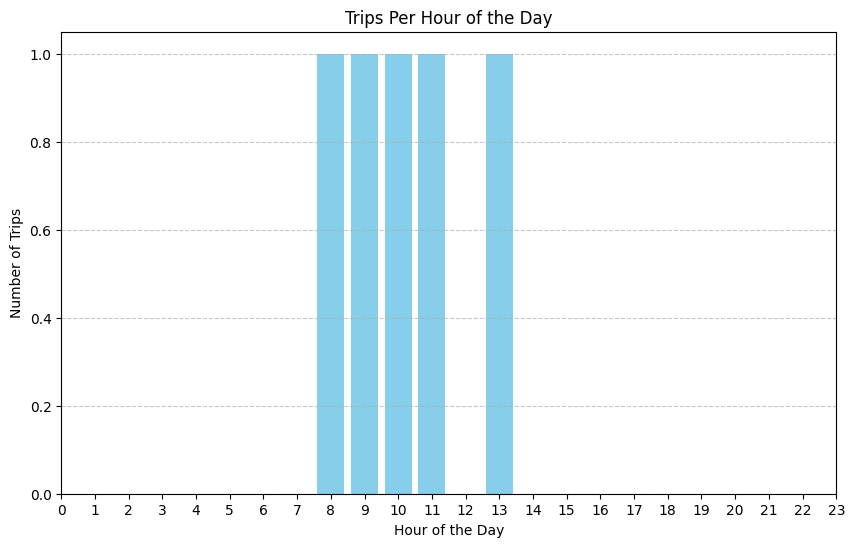

In [31]:
pandas_df = trips_per_hour.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pandas_df["Hour"], pandas_df["count(Hour)"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Trips Per Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [192]:
from pyspark.sql.functions import unix_timestamp

df = spark.createDataFrame([("2024-12-20 08:30:00",)], ["StartTime"])
df.show()
df = df.withColumn("UnixTime", unix_timestamp("StartTime"))
df.show()

+-------------------+
|          StartTime|
+-------------------+
|2024-12-20 08:30:00|
+-------------------+

+-------------------+----------+
|          StartTime|  UnixTime|
+-------------------+----------+
|2024-12-20 08:30:00|1734663600|
+-------------------+----------+



In [193]:
df = df.withColumn("ReadableTime", from_unixtime("UnixTime"))
df.show()

+-------------------+----------+-------------------+
|          StartTime|  UnixTime|       ReadableTime|
+-------------------+----------+-------------------+
|2024-12-20 08:30:00|1734663600|2024-12-20 08:30:00|
+-------------------+----------+-------------------+



In [219]:
from pyspark.sql.functions import col, hour, avg, desc,split
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [220]:
spark=SparkSession.builder.appName("LogAnalysis").getOrCreate()

In [221]:
df=spark.read.text("Log_File.txt")
df.show()

+--------------------+
|               value|
+--------------------+
|"2024-12-18 10:15...|
|"2023-12-18 11:16...|
|"2022-12-18 13:17...|
|"2021-12-18 17:18...|
|"2020-12-18 8:19:...|
|"2019-12-18 9:20:...|
|"2024-12-18 11:21...|
|"2023-12-18 8:22:...|
|"2022-12-18 5:23:...|
|"2021-12-18 5:24:...|
|"2020-12-18 7:25:...|
|"2022-12-18 10:26...|
|"2024-12-18 11:27...|
|"2024-12-18 12:28...|
|"2024-12-18 13:29...|
|"2024-12-18 13:30...|
|"2024-12-18 16:31...|
|"2024-12-18 10:32...|
|"2024-12-18 12:33...|
|"2024-12-18 15:34...|
+--------------------+



In [222]:
from pyspark.sql.functions import split, concat, lit

parsed_df = df.withColumn("timestamp", concat(split(df["value"], " ")[0],lit(" "),split(df["value"]," ")[1])) \
                        .withColumn("log_level", split(df["value"], " ")[2]) \
                        .withColumn("message", concat(split(df["value"], " ")[3],lit(" "),split(df['value']," ")[4],lit(" "),split(df['value']," ")[5]))
#splitting and concating the values 

In [223]:
parsed_df.show()

+--------------------+--------------------+---------+--------------------+
|               value|           timestamp|log_level|             message|
+--------------------+--------------------+---------+--------------------+
|"2024-12-18 10:15...|"2024-12-18 10:15:32|     INFO|     User logged in"|
|"2023-12-18 11:16...|"2023-12-18 11:16:02|    ERROR|     Page not found"|
|"2022-12-18 13:17...|"2022-12-18 13:17:20|     INFO|Data uploaded suc...|
|"2021-12-18 17:18...|"2021-12-18 17:18:45|     INFO|     User logged in"|
|"2020-12-18 8:19:...| "2020-12-18 8:19:12|    ERROR|     Page not found"|
|"2019-12-18 9:20:...| "2019-12-18 9:20:30|     INFO|Data uploaded suc...|
|"2024-12-18 11:21...|"2024-12-18 11:21:55|     INFO|     User logged in"|
|"2023-12-18 8:22:...| "2023-12-18 8:22:18|    ERROR|     Page not found"|
|"2022-12-18 5:23:...| "2022-12-18 5:23:35|     INFO|Data uploaded suc...|
|"2021-12-18 5:24:...| "2021-12-18 5:24:00|     INFO|     User logged in"|
|"2020-12-18 7:25:...| "2

In [224]:
#Count the number of occurrences of each log level
logs = parsed_df.groupBy("log_level").count()
logs.show()

+---------+-----+
|log_level|count|
+---------+-----+
|     INFO|   13|
|    ERROR|    7|
+---------+-----+



In [225]:
#Filter and display only the ERROR logs
error = parsed_df.filter(parsed_df["log_level"] == "ERROR")
error.show()

+--------------------+--------------------+---------+---------------+
|               value|           timestamp|log_level|        message|
+--------------------+--------------------+---------+---------------+
|"2023-12-18 11:16...|"2023-12-18 11:16:02|    ERROR|Page not found"|
|"2020-12-18 8:19:...| "2020-12-18 8:19:12|    ERROR|Page not found"|
|"2023-12-18 8:22:...| "2023-12-18 8:22:18|    ERROR|Page not found"|
|"2020-12-18 7:25:...| "2020-12-18 7:25:25|    ERROR|Page not found"|
|"2024-12-18 12:28...|"2024-12-18 12:28:05|    ERROR|Page not found"|
|"2024-12-18 16:31...|"2024-12-18 16:31:50|    ERROR|Page not found"|
|"2024-12-18 15:34...|"2024-12-18 15:34:10|    ERROR|Page not found"|
+--------------------+--------------------+---------+---------------+



In [227]:
from pyspark.sql.functions import regexp_replace, col

# To Remove the extra double quote from the timestamp column
cleaned_df = parsed_df.withColumn("timestamp", regexp_replace("timestamp", r'^"|"$', ""))

cleaned_df.show()


+--------------------+-------------------+---------+--------------------+
|               value|          timestamp|log_level|             message|
+--------------------+-------------------+---------+--------------------+
|"2024-12-18 10:15...|2024-12-18 10:15:32|     INFO|     User logged in"|
|"2023-12-18 11:16...|2023-12-18 11:16:02|    ERROR|     Page not found"|
|"2022-12-18 13:17...|2022-12-18 13:17:20|     INFO|Data uploaded suc...|
|"2021-12-18 17:18...|2021-12-18 17:18:45|     INFO|     User logged in"|
|"2020-12-18 8:19:...| 2020-12-18 8:19:12|    ERROR|     Page not found"|
|"2019-12-18 9:20:...| 2019-12-18 9:20:30|     INFO|Data uploaded suc...|
|"2024-12-18 11:21...|2024-12-18 11:21:55|     INFO|     User logged in"|
|"2023-12-18 8:22:...| 2023-12-18 8:22:18|    ERROR|     Page not found"|
|"2022-12-18 5:23:...| 2022-12-18 5:23:35|     INFO|Data uploaded suc...|
|"2021-12-18 5:24:...| 2021-12-18 5:24:00|     INFO|     User logged in"|
|"2020-12-18 7:25:...| 2020-12-18 7:25

In [228]:
cleaned_df = cleaned_df.withColumn("message", regexp_replace(col("message"), r'^"|"$', ""))

cleaned_df.show()


+--------------------+-------------------+---------+--------------------+
|               value|          timestamp|log_level|             message|
+--------------------+-------------------+---------+--------------------+
|"2024-12-18 10:15...|2024-12-18 10:15:32|     INFO|      User logged in|
|"2023-12-18 11:16...|2023-12-18 11:16:02|    ERROR|      Page not found|
|"2022-12-18 13:17...|2022-12-18 13:17:20|     INFO|Data uploaded suc...|
|"2021-12-18 17:18...|2021-12-18 17:18:45|     INFO|      User logged in|
|"2020-12-18 8:19:...| 2020-12-18 8:19:12|    ERROR|      Page not found|
|"2019-12-18 9:20:...| 2019-12-18 9:20:30|     INFO|Data uploaded suc...|
|"2024-12-18 11:21...|2024-12-18 11:21:55|     INFO|      User logged in|
|"2023-12-18 8:22:...| 2023-12-18 8:22:18|    ERROR|      Page not found|
|"2022-12-18 5:23:...| 2022-12-18 5:23:35|     INFO|Data uploaded suc...|
|"2021-12-18 5:24:...| 2021-12-18 5:24:00|     INFO|      User logged in|
|"2020-12-18 7:25:...| 2020-12-18 7:25

In [229]:
df = cleaned_df.withColumn("Hour", hour("timestamp"))

df.show()

+--------------------+-------------------+---------+--------------------+----+
|               value|          timestamp|log_level|             message|Hour|
+--------------------+-------------------+---------+--------------------+----+
|"2024-12-18 10:15...|2024-12-18 10:15:32|     INFO|      User logged in|  10|
|"2023-12-18 11:16...|2023-12-18 11:16:02|    ERROR|      Page not found|  11|
|"2022-12-18 13:17...|2022-12-18 13:17:20|     INFO|Data uploaded suc...|  13|
|"2021-12-18 17:18...|2021-12-18 17:18:45|     INFO|      User logged in|  17|
|"2020-12-18 8:19:...| 2020-12-18 8:19:12|    ERROR|      Page not found|   8|
|"2019-12-18 9:20:...| 2019-12-18 9:20:30|     INFO|Data uploaded suc...|   9|
|"2024-12-18 11:21...|2024-12-18 11:21:55|     INFO|      User logged in|  11|
|"2023-12-18 8:22:...| 2023-12-18 8:22:18|    ERROR|      Page not found|   8|
|"2022-12-18 5:23:...| 2022-12-18 5:23:35|     INFO|Data uploaded suc...|   5|
|"2021-12-18 5:24:...| 2021-12-18 5:24:00|     INFO|

In [230]:
df=df.groupBy('Hour').agg(count('log_level').alias("No of Logs"))
df.show()

+----+----------+
|Hour|No of Logs|
+----+----------+
|  12|         2|
|  13|         3|
|  16|         1|
|   5|         2|
|  15|         1|
|  17|         1|
|   9|         1|
|   8|         2|
|   7|         1|
|  10|         3|
|  11|         3|
+----+----------+



In [231]:
import matplotlib.pyplot as plt

In [232]:
df=df.toPandas()

Text(0.5, 1.0, 'Visualization')

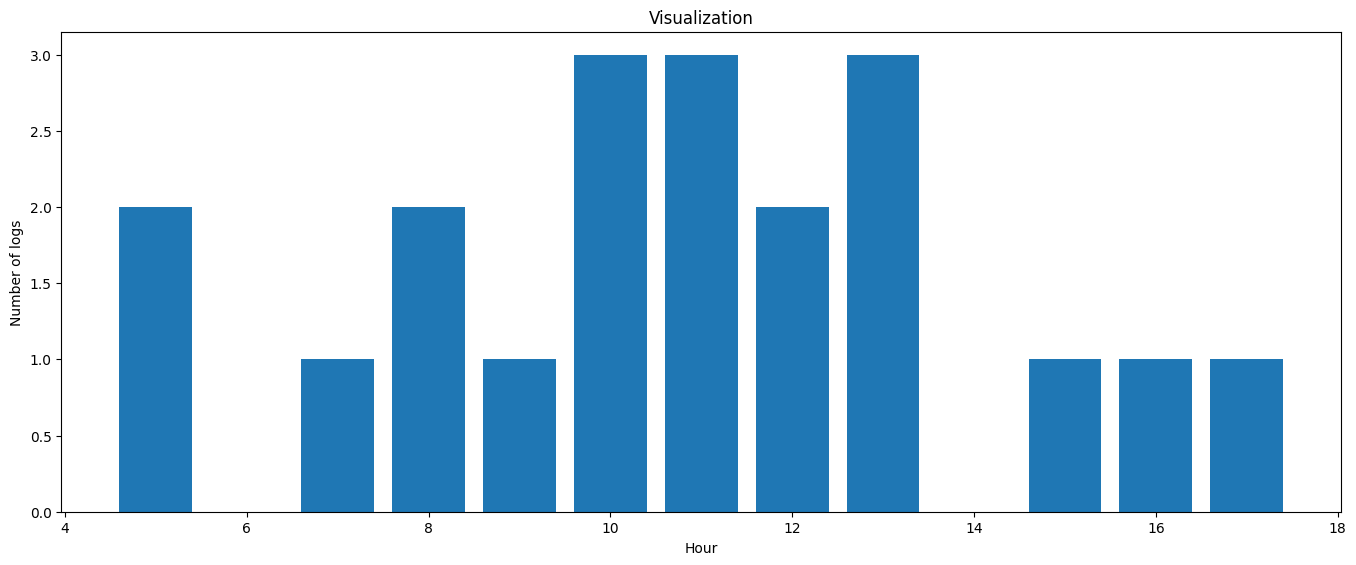

In [233]:
fig=plt.figure(figsize=(16,6))
axes=fig.add_axes([0.1,0.1,0.8,0.8])
axes.bar(df['Hour'],df['No of Logs'])
axes.set_xlabel("Hour")
axes.set_ylabel("Number of logs")
axes.set_title("Visualization")


In [234]:
spark.stop()